In [77]:
import os
import sys
import numpy as np
import opendp.whitenoise.core as wn
import pandas as pd
import random
import warnings
warnings.filterwarnings('ignore')

In [79]:
DATASET_PATH = '../../dataset/complete_patients_dataset.csv'
NSIZE = 303

def get_columns(dataset_path=DATASET_PATH):
    df = pd.read_csv(dataset_path)
    return [*df.columns]

def get_states(dataset_path=DATASET_PATH):
    df = pd.read_csv(dataset_path)
    return [*df['state'].unique()]

def prepare_dataset(dataset_path=DATASET_PATH, nsize=NSIZE):
    return wn.Dataset(path = dataset_path, column_names=get_columns())

## Analysis

### Histograms

Now, we can analyze the dataset to visualize data. We will work about the sensible data: sex, country and age.

In [81]:
def create_sex_histograms(data):
    sex_histogram_geometric = wn.dp_histogram(
            wn.to_bool(data['sex'], true_label="0"),
            upper=NSIZE,
            privacy_usage = {'epsilon': .5, 'delta': 0.00001 }
        )
    sex_prep = wn.histogram(wn.to_bool(data['sex'], true_label="0"), null_value = True)
    sex_histogram_laplace = wn.laplace_mechanism(sex_prep, privacy_usage={"epsilon": 0.4, "delta": .000001})
    return sex_histogram_geometric, sex_histogram_laplace

def create_state_histograms(data):
    states = get_states()
    state_histogram_geometric = wn.dp_histogram(
            data['state'],
            categories=states,
            null_value=states[0],
            privacy_usage = {'epsilon': 0.2}
        )

    state_prep = wn.histogram(data['state'], categories=states,
            null_value=states[0])
    state_histogram_laplace = wn.laplace_mechanism(state_prep, 
            privacy_usage={"epsilon": 0.5, "delta": .000001})
    return state_histogram_geometric, state_histogram_laplace

def create_age_histograms(data):
    age_edges = list(range(20, 80, 10))
    age_histogram_geometric = wn.dp_histogram(
            wn.to_int(data['age'], lower=20, upper=80),
            edges = age_edges,
            upper = NSIZE,
            null_value = 20,
            privacy_usage = {'epsilon': 0.5}
        )

    age_prep = wn.histogram(wn.to_int(data['age'], lower=20, upper=80),
                                     edges=age_edges, null_value=20)
    age_histogram_laplace = wn.laplace_mechanism(age_prep, privacy_usage={"epsilon": 0.5, "delta": .000001})
    return age_histogram_geometric, age_histogram_laplace

Using Open Differential Privacy we can add Noise to dataset and protect the data. We can create histograms using geometric or Laplace an continous, categorical and boolean variable.

In [83]:

with wn.Analysis() as analysis:
    data = prepare_dataset()
    sex_histogram_geometric, sex_histogram_laplace = create_sex_histograms(data)
    state_histogram_geometric, state_histogram_laplace = create_state_histograms(data)
    age_histogram_geometric, age_histogram_laplace = create_age_histograms(data)
analysis.release()

print("Sex histogram Geometric DP release:      " + str(sex_histogram_geometric.value))
print("Sex histogram Laplace DP release:        " + str(sex_histogram_laplace.value))

print("State histogram Geometric DP release:      " + str(state_histogram_geometric.value))
print("State histogram Laplace DP release:        " + str(state_histogram_laplace.value))

print("Age histogram Geometric DP release:      " + str(age_histogram_geometric.value))
print("Age histogram Laplace DP release:        " + str(age_histogram_laplace.value))

Sex histogram Geometric DP release:      [ 83 208]
Sex histogram Laplace DP release:        [ 96.85853497 205.42061982]
State histogram Geometric DP release:      [20  9 21 18  9 10 17 40 10 28 12  1 22 34  9 20]
State histogram Laplace DP release:        [14.49703242 11.51005056 32.18964179  8.49297596  8.0659423  15.53802966
  7.02253743 28.87539567 22.81880429 38.84157075 22.99037016  1.58508526
 17.82476892 24.26280498  7.2965696  10.12448203]
Age histogram Geometric DP release:      [   4 -161   95  158  163   11]
Age histogram Laplace DP release:        [ -1.32489179   5.57069791  66.89709844 128.02308168  81.6653435
  10.25411805]


At first, we will show the histograms for a real data.

In [85]:
import matplotlib.pyplot as plt

def show_histogram(data, bins, title):
    n_data, bins, patches = plt.hist(data, bins=bins, color='#0504aa',
                                alpha=0.7, rwidth=0.85)
    plt.grid(axis='y', alpha=0.75)
    plt.xlabel(title)
    plt.ylabel('Frequency')
    plt.title(f'True Dataset {title} Distribution')
    plt.show()
    return n_data

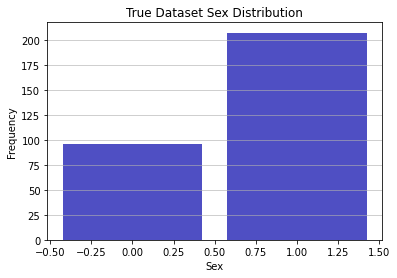

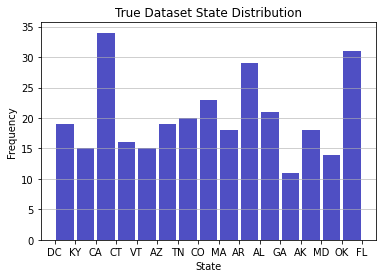

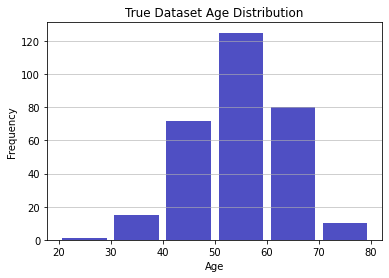

In [87]:
df = pd.read_csv(DATASET_PATH)

sex = list(df[:]['sex'])
states = list(df[:]['state'])
age = list(df[:]['age'])

n_sex = show_histogram(sex, [-0.5,0.5,1.5], "Sex")
n_state = show_histogram(states, list(range(len(get_states()))), "State")
n_age = show_histogram(age, list(range(20,90,10)), "Age")

Now, we can compare the real histogram with the histogram generate with Noise. The data are different, but we can observe the same patterns. For example, there are more females than males. Futhermore, the country and age distribution are very similar.

In [89]:

def plot(ax, data, title, colors, xlabels, legend_names, width=0.2):
    positions = [
        [i+width*column for column in range(len(data[0]))] for i in range(len(data))]
 
    for position, value in zip(positions, data):
        ax.bar(position,
               value,
               width,
               alpha=0.75,
               color=colors
               )
 
    ax.set_title(title)
    ax.set_xticks([p[0] + 1.5 * width for p in positions])
    ax.set_xticklabels(xlabels)
 
    proxies = [ax.bar([0], [0], width=0, color=c, alpha=0.75)[0]
               for c in colors]
    ax.legend((proxies), legend_names, loc='upper left')
 
    ax.set_xlim(positions[0][0]-width, positions[-1][0]+width*len(data[0]))
    ax.set_ylim([0, max(max(l) for l in data)*1.2])
 
    plt.grid()
    plt.show()
    plt.clf()

def show_dp_and_real_histogram(title, labels, n_data, geometric_histogram, laplace_histogram):
    colorseq = ["forestgreen", "indianred", "orange", "orangered", "orchid"]
    legend = ['True Value', 'DP Geometric', 'DP Laplace']
    fig = plt.figure()
    ax = fig.add_subplot(111)
    data = [n_data, geometric_histogram.value, laplace_histogram.value]
    plot(ax, list(map(list, zip(*data))), title, colorseq, labels, legend)

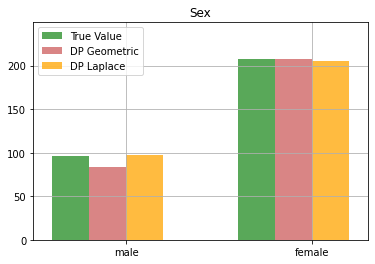

<Figure size 432x288 with 0 Axes>

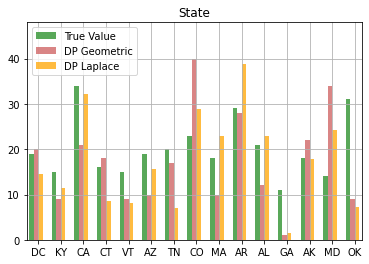

<Figure size 432x288 with 0 Axes>

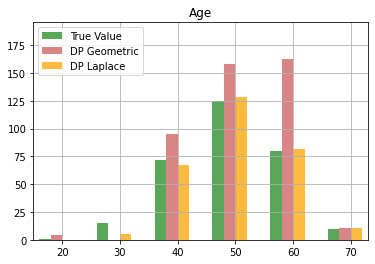

<Figure size 432x288 with 0 Axes>

In [108]:
show_dp_and_real_histogram("Sex", ['male','female'], n_sex, sex_histogram_geometric, sex_histogram_laplace)
show_dp_and_real_histogram("State", get_states(), n_state, state_histogram_geometric, state_histogram_laplace)
show_dp_and_real_histogram("Age", list(range(20,80,10)), n_age, age_histogram_geometric, age_histogram_laplace)

Also, We can query data from dataset with Differential Privacy Noise to protect data. We have to create a reader and specify the metadata. Now, we can query the dataset.

In [93]:
import pandas as pd
from opendp.whitenoise.sql import PandasReader, PrivateReader
from opendp.whitenoise.metadata import CollectionMetadata

DATASET_METADATA_PATH = '../../dataset/uci_dataset.yml'


pums = pd.read_csv(DATASET_PATH)
meta = CollectionMetadata.from_file(DATASET_METADATA_PATH)

reader = PandasReader(meta, pums)
private_reader = PrivateReader(meta, reader)

For example, We can get the average of age for the USA people. We can use the reader with Differential Privacy Noise and compare with the real data. As you can see, the data is similar, but We can protect the real data using reader with Differential Privacy.

In [95]:
query = 'SELECT AVG(age) FROM UCI.PEOPLE WHERE state == "DC"'
result = private_reader.execute_typed(query)
print(result)

Col1     
 ---------
  97.72597


In [97]:
df[df['state'] == 'DC']['age'].mean()

57.89473684210526

Also, We can count the USA people. As you can see, the data is protected by Differential Privacy. 

In [99]:
query = 'SELECT COUNT(state) FROM UCI.PEOPLE WHERE state == "DC"'
result = private_reader.execute_typed(query)
print(result)

Col1   
 -------
  24    


In [100]:
df[df['state'] == 'DC']['state'].count()

19

You can use this to make complex queries

In [101]:
query = 'SELECT sex, AVG(age) as age, COUNT(*) as people, AVG(cholesterol) as cholesterol FROM UCI.PEOPLE GROUP BY sex'  
result = private_reader.execute_typed(query)
print(result)

sex |age      |people |cholestero
 ----|---------|-------|----------
  0  | 62.95858| 104   | 238.94080
  1  | 57.09679| 203   | 243.98222


In [102]:
grouped = df.groupby(['sex'])
grouped['age'].mean()

sex
0    55.677083
1    53.758454
Name: age, dtype: float64

In [103]:
grouped['sex'].count()

sex
0     96
1    207
Name: sex, dtype: int64

In [104]:
grouped['cholesterol'].mean()

sex
0    261.302083
1    239.289855
Name: cholesterol, dtype: float64

### Protect personal data
Working on dataset, you can see the row with a personal data. For example, we can identify a person with country USA, 71 years old and male. Using the reader, we can protect the data.

In [105]:
df[(df['state'] == 'AK') & (df['age'] == 71) & (df['sex'] == 0)]

,age,sex,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar,rest_ecg,max_heart_rate_achieved,exercise_induced_angina,st_depression,...,state,address,city,postalCode,name,ssn,pregnant,diabetic,asthmatic,observation
25,71,0,1,160,302,0,1,162,0,0.4,...,AK,600 West 19th Avenue,Anchorage,99503,Krista Upson,747-62-6621,0,0,0,Krista Upson from Anchorage. Last visit on 08/...


In [106]:
query = 'SELECT COUNT(state) FROM UCI.PEOPLE WHERE state == "AK" AND age == 71 AND sex == 0'
result = private_reader.execute_typed(query)
print(result)

Col1   
 -------
  0     
